# Food Delivery Time Prediction



# Import libraries

In [35]:

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import missingno as msno # to check missing values
import shap  # to check feature importance of our model
from matplotlib import pyplot as plt
%matplotlib inline


# for Multivariate imputation (iterative imputer)
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer


# For Model 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error   
import xgboost as xgb
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor,Pool


# Load Train and Test Data

In [149]:
train_df=pd.read_csv('historical_data.csv')
print(train_df.shape)
train_df.head(3)

(197428, 9)


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0


In [150]:
test_df=pd.read_csv('predict_data.csv')
print(test_df.shape)
test_df.head(2)

(54778, 9)


,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895


In [151]:
# checking datatypes 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

In [152]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   market_id                                     54528 non-null  float64
 1   created_at                                    54778 non-null  object 
 2   store_id                                      54778 non-null  int64  
 3   subtotal                                      54778 non-null  int64  
 4   total_onshift_dashers                         50145 non-null  float64
 5   total_busy_dashers                            50145 non-null  float64
 6   total_outstanding_orders                      50145 non-null  float64
 7   estimated_store_to_consumer_driving_duration  54767 non-null  float64
 8   delivery_id                                   54778 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 3.8+ MB


In [153]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
market_id,54528.0,3.031360,1.531606,1.0,2.0,3.0,4.0,6.0
store_id,54778.0,3489.640969,2050.221801,2.0,1661.0,3518.0,5247.0,6986.0
subtotal,54778.0,2715.758772,1897.919808,0.0,1420.0,2220.0,3415.0,29925.0
total_onshift_dashers,50145.0,49.076179,37.594714,-1.0,19.0,41.0,71.0,175.0
total_busy_dashers,50145.0,43.515206,34.051339,-4.0,16.0,36.0,63.0,169.0
total_outstanding_orders,50145.0,62.566756,56.378953,-9.0,19.0,45.0,91.0,292.0
estimated_store_to_consumer_driving_duration,54767.0,547.765406,220.459715,0.0,385.0,544.0,703.0,1550.0
delivery_id,54778.0,126118.103454,72683.611935,20.0,62938.5,126194.0,188916.0,252031.0


In [154]:
train_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
market_id,196441.0,NaN,NaN,NaN,2.978706,1.524867,1.0,2.0,3.0,4.0,6.0
created_at,197428,180985,2015-02-11 19:50:43,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actual_delivery_time,197421,178110,2015-02-11 20:40:45,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_id,197428.0,NaN,NaN,NaN,3530.510272,2053.496711,1.0,1686.0,3592.0,5299.0,6987.0
subtotal,197428.0,NaN,NaN,NaN,2682.331402,1823.093688,0.0,1400.0,2200.0,3395.0,27100.0
total_onshift_dashers,181166.0,NaN,NaN,NaN,44.808093,34.526783,-4.0,17.0,37.0,65.0,171.0
total_busy_dashers,181166.0,NaN,NaN,NaN,41.739747,32.145733,-5.0,15.0,34.0,62.0,154.0
total_outstanding_orders,181166.0,NaN,NaN,NaN,58.050065,52.66183,-6.0,17.0,41.0,85.0,285.0
estimated_store_to_consumer_driving_duration,196902.0,NaN,NaN,NaN,545.358935,219.352902,0.0,382.0,544.0,702.0,2088.0


<AxesSubplot:>

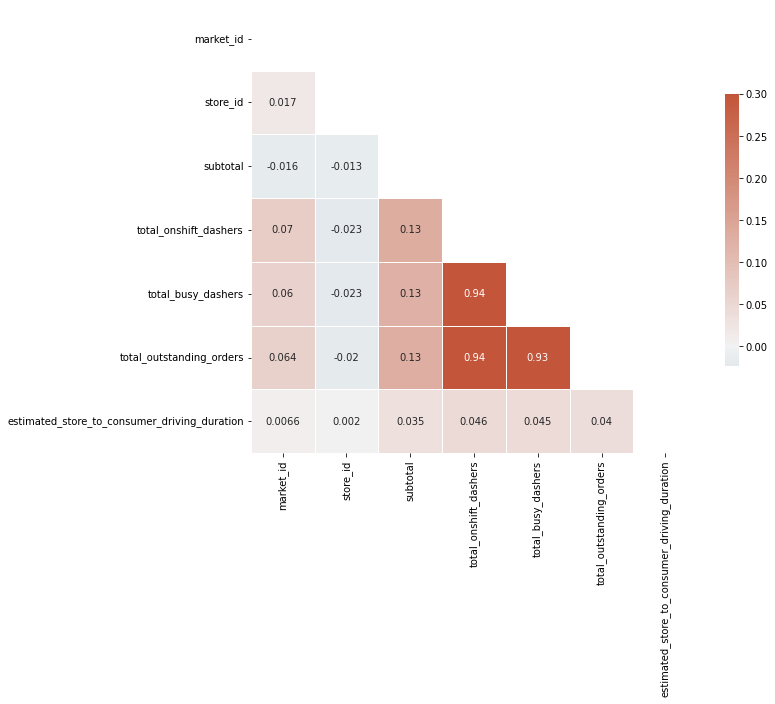

In [155]:
# check Correlation between features
corr=train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Data Processing

### Feature tuning and feature extraction 
- Converting `created_at` and `actual_delivery_time` to get the actual delivery in `seconds`
- Extract other data like the hour of order , day_name , month, etc

In [156]:
for i in ['created_at','actual_delivery_time']:
    train_df[i]=pd.to_datetime(train_df[i])
    

# extract features from create_at column

train_df['Day_of_week']=train_df.created_at.dt.dayofweek
train_df['order_Day_name']=train_df.created_at.dt.day_name()
train_df['order_mnth']=train_df.created_at.dt.month 
train_df['order_hour']=train_df.created_at.dt.hour 
train_df['AM_PM']=train_df.created_at.dt.strftime('%p') # identify AM/PM


# calculate delivery actual time in second
train_df['actual_delivery_duration']=(train_df.actual_delivery_time-train_df.created_at).dt.seconds


# getting the estimation error
train_df['estimate_error']=train_df.actual_delivery_duration-train_df.estimated_store_to_consumer_driving_duration




# prepare testing dataset
test_df['created_at']=pd.to_datetime(test_df['created_at'])
test_df['Day_of_week']=test_df.created_at.dt.dayofweek
test_df['order_mnth']=test_df.created_at.dt.month
test_df["order_hour"]=test_df.created_at.dt.hour
test_df['AM_PM']=test_df.created_at.dt.strftime('%p') # identify AM/PM


## Ananmolies
- Removed one record for order in month october
- Remove two order for hour 8 took more than 20000 second to deliver
- Replaced negative values on total_onshift_dashers, total_busy_dashers and total_outstanding_orders columns
- Replace zero values on subtotal with median 
- Removed deliveried that took moere than 8000 seconds drop values 

In [157]:
train_df.groupby('order_mnth').created_at.count().to_frame()

,created_at
order_mnth,
1,68482
2,128945
10,1


In [158]:
# check order month in testing dataset
pd.to_datetime(test_df.created_at).dt.month.unique()

array([2])

In [159]:
# removing order for October
idx=train_df[train_df.order_mnth==10].index
train_df=train_df[~train_df.index.isin(idx)]


In [160]:
# order time
train_df.order_hour.value_counts().sort_values().to_frame()

,order_hour
8,2
7,11
14,40
15,538
6,1416
16,2109
17,3413
18,5100
5,7095
23,8163


In [161]:
# we have only 2 orders on the 8 am and both took more than 6 hours to deliver , both need to be removed 
# at the end i will remove deliveries took more than --
train_df[train_df.order_hour==8].actual_delivery_duration

63505     32690.0
185550    28279.0
Name: actual_delivery_duration, dtype: float64

In [162]:
train_df.drop([63505,185550], inplace=True)

In [163]:
#divided them into 3 groups 0-5, 5-17,17-23
train_df['time_group']=pd.cut(train_df.order_hour.values ,[-1,5,17,23] , labels=['[0-5]','[5-17]','[17-23]'])

#### Interestingly - Estimatation error are in the same range across all market_ids~ 2000 second

In [164]:

train_df.groupby(['market_id','time_group']).estimate_error.agg(['mean','median'])

mean  median
market_id time_group                     
1.0       [0-5]       2677.143187  2402.0
          [5-17]      2503.013277  2246.0
          [17-23]     2337.253583  2087.0
2.0       [0-5]       2371.949542  2195.0
          [5-17]      1951.691674  1814.5
          [17-23]     1884.928628  1746.0
3.0       [0-5]       2352.097135  2126.0
          [5-17]      2667.901310  2386.0
          [17-23]     2208.455953  1991.0
4.0       [0-5]       2432.006230  2274.0
          [5-17]      1862.538462  1710.0
          [17-23]     2017.864449  1823.0
5.0       [0-5]       2415.583734  2222.0
          [5-17]      2074.003252  1857.0
          [17-23]     1929.667458  1761.0
6.0       [0-5]       2379.261836  2156.0
          [5-17]      2167.244541  1888.0
          [17-23]     2131.551798  1892.0

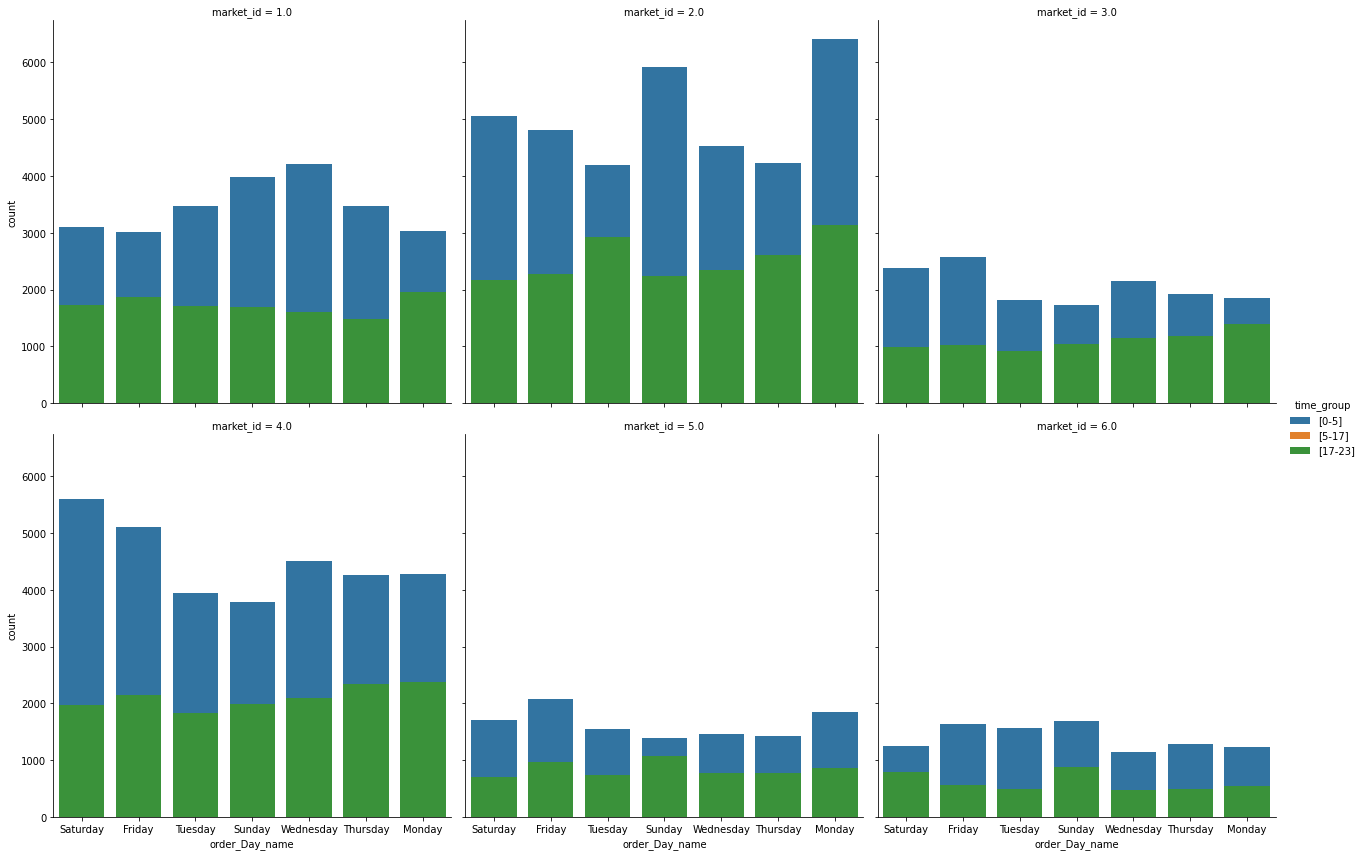

In [165]:
g = sns.FacetGrid(train_df, col="market_id", height=6, aspect=1, col_wrap=3,hue="time_group")
g.map(sns.countplot, "order_Day_name")
g.add_legend()

<AxesSubplot:xlabel='market_id', ylabel='estimate_error'>

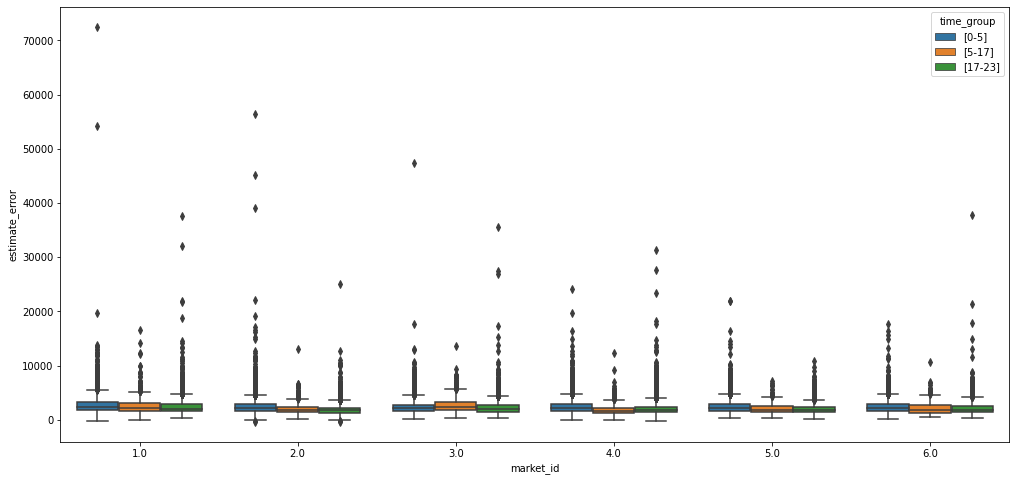

In [166]:
plt.figure(figsize=(17,8))
sns.boxplot(x=train_df.market_id, y=train_df.estimate_error, hue=train_df.time_group)

<AxesSubplot:xlabel='market_id', ylabel='subtotal'>

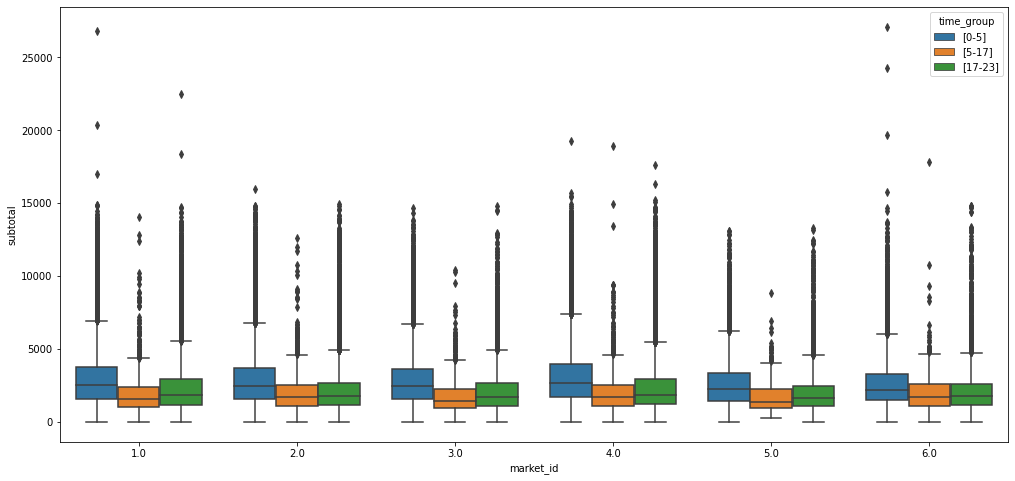

In [167]:
plt.figure(figsize=(17,8))
sns.boxplot(x=train_df.market_id, y=train_df.subtotal, hue=train_df.time_group)

In [168]:
stores=train_df.groupby('store_id').market_id.nunique().to_frame()
stores[stores.market_id>1].head()

,market_id
store_id,
4,4
9,2
16,4
17,3
19,2


AxesSubplot(0.125,0.125;0.775x0.755)


<AxesSubplot:>

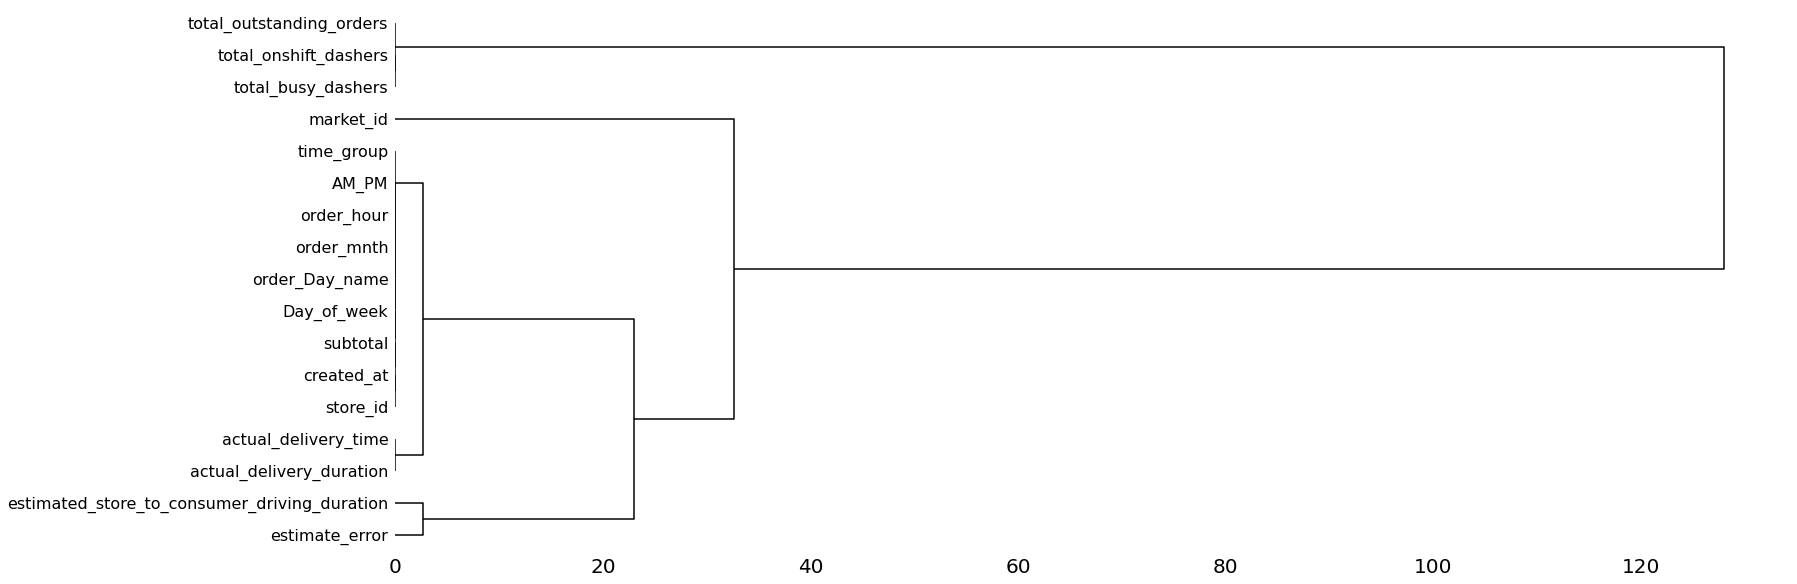

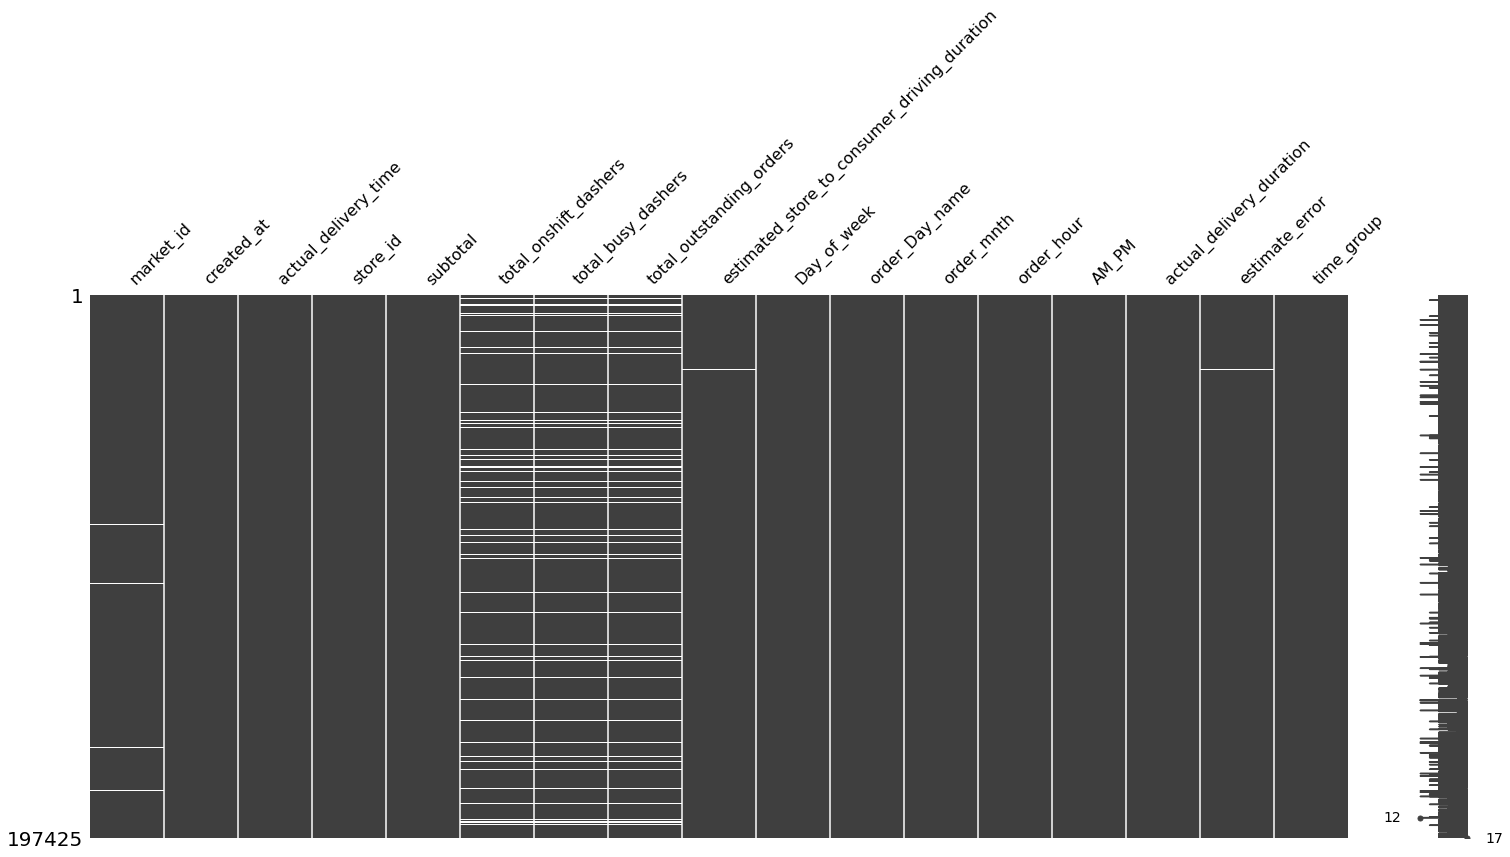

In [169]:
#Checking mssing values , we want make sure there are random not systematic
# Dendogram and heatmap 
print(msno.dendrogram(train_df, orientation='right'))
msno.matrix(train_df)

In [170]:
#using Iterative imputer to fill null values

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer

imputer = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1), verbose=2, 
                       max_iter=10,  imputation_order='roman', add_indicator=False)



imputed=imputer.fit_transform(train_df[['market_id','store_id']])

train_df[['market_id','store_id']]=imputed


## Imputed Market ID on testing dataset


test_imputed=imputer.transform(test_df[['market_id','store_id']])

test_df[['market_id','store_id']]=test_imputed


[IterativeImputer] Completing matrix with shape (197425, 2)
[IterativeImputer] Ending imputation round 1/10, elapsed time 4.46
[IterativeImputer] Change: 3.021284069273766, scaled tolerance: 6.987 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (54778, 2)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.11


In [171]:
train_df.isnull().sum()

market_id                                           0
created_at                                          0
actual_delivery_time                                7
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16261
total_busy_dashers                              16261
total_outstanding_orders                        16261
estimated_store_to_consumer_driving_duration      526
Day_of_week                                         0
order_Day_name                                      0
order_mnth                                          0
order_hour                                          0
AM_PM                                               0
actual_delivery_duration                            7
estimate_error                                    533
time_group                                          0
dtype: int64

In [172]:
test_df.isnull().sum()

market_id                                          0
created_at                                         0
store_id                                           0
subtotal                                           0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
Day_of_week                                        0
order_mnth                                         0
order_hour                                         0
AM_PM                                              0
dtype: int64

In [173]:
# Negative values on "total_onshift_dashers", "total_busy_dashers" and "total_outstanding_orders’ columns and I replaced them with median value.

train_df[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders','subtotal']].describe()


,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal
count,181164.000000,181164.000000,181164.000000,197425.000000
mean,44.808588,41.740208,58.050705,2682.341998
std,34.526653,32.145611,52.661768,1823.104304
min,-4.000000,-5.000000,-6.000000,0.000000
25%,17.000000,15.000000,17.000000,1400.000000
50%,37.000000,34.000000,41.000000,2200.000000
75%,65.000000,62.000000,85.000000,3395.000000
max,171.000000,154.000000,285.000000,27100.000000


In [174]:
train_df[train_df.total_onshift_dashers<0][:4]

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,Day_of_week,order_Day_name,order_mnth,order_hour,AM_PM,actual_delivery_duration,estimate_error,time_group
6034,3.0,2015-02-14 01:48:58,2015-02-14 03:00:13,90.0,3538,-2.0,2.0,10.0,266.0,5,Saturday,2,1,AM,4275.0,4009.0,[0-5]
12888,3.0,2015-01-21 21:02:32,2015-01-21 21:41:03,2649.0,986,-2.0,5.0,1.0,787.0,2,Wednesday,1,21,PM,2311.0,1524.0,[17-23]
26395,3.0,2015-02-08 18:28:15,2015-02-08 19:17:31,2772.0,1327,-1.0,6.0,6.0,368.0,6,Sunday,2,18,PM,2956.0,2588.0,[17-23]
30897,3.0,2015-02-07 19:55:46,2015-02-07 20:46:27,793.0,1202,-1.0,9.0,5.0,773.0,5,Saturday,2,19,PM,3041.0,2268.0,[17-23]


In [175]:
cols=['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders','subtotal']

for i in cols:
    print('# negative values in {:22}'.format(i),'\t\t', train_df[train_df[i]<0].shape[0])

# negative values in total_onshift_dashers  		 21
# negative values in total_busy_dashers     		 21
# negative values in total_outstanding_orders 		 44
# negative values in subtotal               		 0


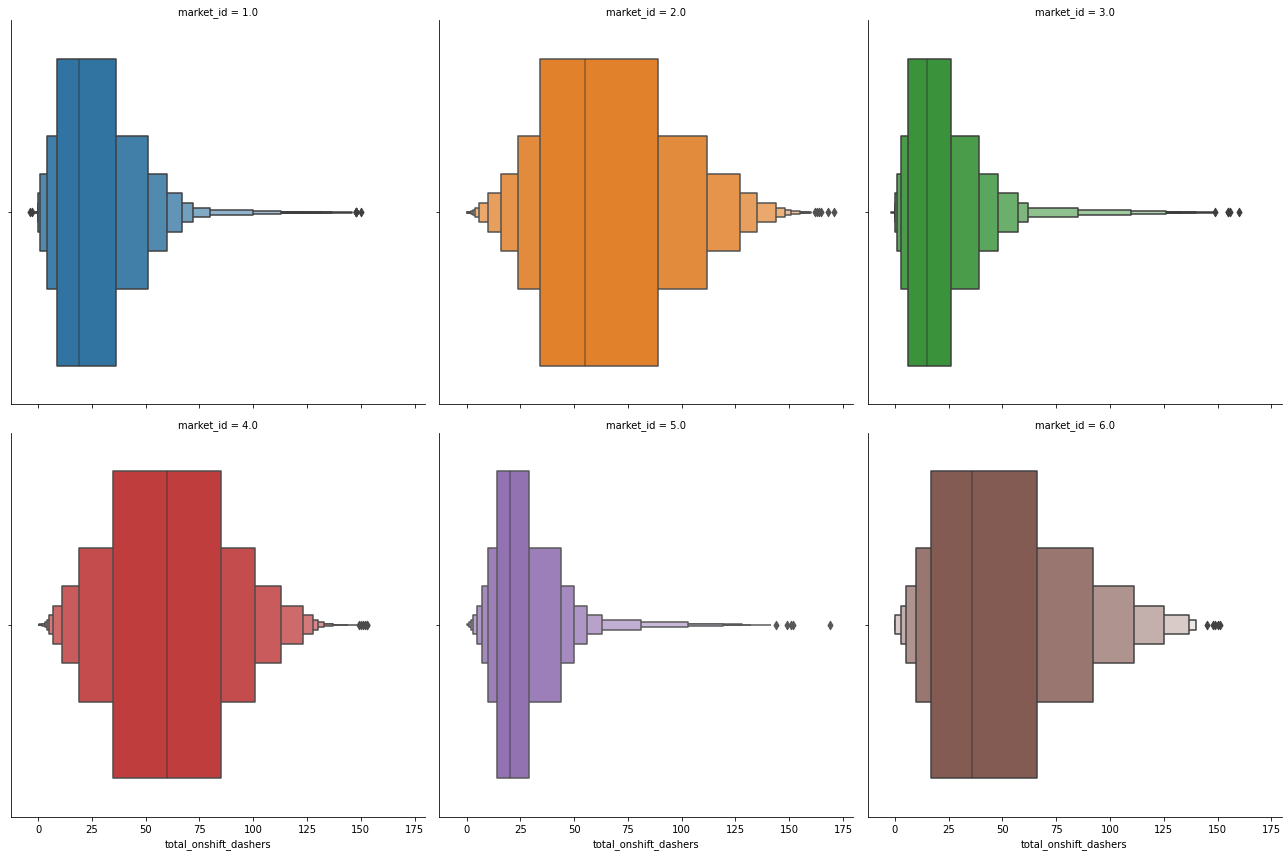

In [176]:
# checking delivery time on Market_ID
g = sns.FacetGrid(train_df, col="market_id", height=6, aspect=1, col_wrap=3,hue="market_id")
g.map(sns.boxenplot, "total_onshift_dashers") 

##### From 8am - 3pm, there are less dashers working in this peirod.
##### Market 2 & 4 has more avaliable dashers, suggesting they might be a bigger city/region compared to other markets.]

In [177]:
#replace negative values with median 
train_df.loc[train_df.total_onshift_dashers < 0, 'total_onshift_dashers'] = train_df.total_onshift_dashers.median()
train_df.loc[train_df.total_busy_dashers < 0, 'total_busy_dashers'] = train_df.total_busy_dashers.median()
train_df.loc[train_df.total_outstanding_orders < 0, 'total_outstanding_orders'] = train_df.total_outstanding_orders.median()

# replace zero values on subtotal column with median 
train_df.loc[train_df.subtotal == 0, 'subtotal'] = train_df.subtotal.median()



############ Same method for testing dataset



test_df.loc[test_df.total_onshift_dashers < 0, 'total_onshift_dashers'] = test_df.total_onshift_dashers.median()
test_df.loc[test_df.total_busy_dashers < 0, 'total_busy_dashers'] = test_df.total_busy_dashers.median()
test_df.loc[test_df.total_outstanding_orders < 0, 'total_outstanding_orders'] = test_df.total_outstanding_orders.median()
test_df.loc[test_df.subtotal == 0, 'subtotal'] = test_df.subtotal.median()

In [178]:
# replace nan with the Same market_ID and on the same order_hour
# use medain value as data skewed 

train_df["total_onshift_dashers"] =train_df.groupby(["market_id",'order_hour'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.median()))
train_df["total_busy_dashers"] =train_df.groupby(["market_id",'order_hour'])['total_busy_dashers'].transform(lambda x: x.fillna(x.median()))
train_df["total_outstanding_orders"] =train_df.groupby(["market_id",'order_hour'])['total_outstanding_orders'].transform(lambda x: x.fillna(x.median()))




# same method for testing dataset
test_df["total_onshift_dashers"] =test_df.groupby(["market_id",'order_hour'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.mean()))
test_df["total_busy_dashers"] =test_df.groupby(["market_id",'order_hour'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))
test_df["total_outstanding_orders"] =test_df.groupby(["market_id",'order_hour'])['total_outstanding_orders'].transform(lambda x: x.fillna(x.mean()))


In [179]:
train_df[train_df.market_id.isna()].isnull().sum()

market_id                                       0.0
created_at                                      0.0
actual_delivery_time                            0.0
store_id                                        0.0
subtotal                                        0.0
total_onshift_dashers                           0.0
total_busy_dashers                              0.0
total_outstanding_orders                        0.0
estimated_store_to_consumer_driving_duration    0.0
Day_of_week                                     0.0
order_Day_name                                  0.0
order_mnth                                      0.0
order_hour                                      0.0
AM_PM                                           0.0
actual_delivery_duration                        0.0
estimate_error                                  0.0
time_group                                      0.0
dtype: float64

In [180]:
test_df[test_df.market_id.isna()].isnull().sum()

market_id                                       0.0
created_at                                      0.0
store_id                                        0.0
subtotal                                        0.0
total_onshift_dashers                           0.0
total_busy_dashers                              0.0
total_outstanding_orders                        0.0
estimated_store_to_consumer_driving_duration    0.0
delivery_id                                     0.0
Day_of_week                                     0.0
order_mnth                                      0.0
order_hour                                      0.0
AM_PM                                           0.0
dtype: float64

### Handling Missing Values

- As  I checked, each Store_id didn’t belong to a unique market_id, however, the majority of them belong to one market_id.  Multivariate imputation (iterative imputer). I used RandomForest as a function inside imputer to substitute the missing values.

-  actual_delivery_time: I believe this might have happened due to various reasons like canceled orders or system issues. I removed these seven rows. 

- There are 16,262 rows with missing values for "total_onshift_dashers" ,"total_busy_dashers" and "total_outstanding_orders’. I have grouped records by ‘market_id’ and ‘order_hour’ and then substituted the null values with median value on each feature. 

- Estimated_store_to_consumer_driving_duration has 526 missing values and i don't use this column in my model. 

In [181]:
idx=train_df[train_df.actual_delivery_time.isna()].index
train_df=train_df[~train_df.index.isin(idx)]

In [182]:
train_df.isnull().sum().to_frame()

,0
market_id,0
created_at,0
actual_delivery_time,0
store_id,0
subtotal,0
total_onshift_dashers,2
total_busy_dashers,2
total_outstanding_orders,2
estimated_store_to_consumer_driving_duration,526
Day_of_week,0


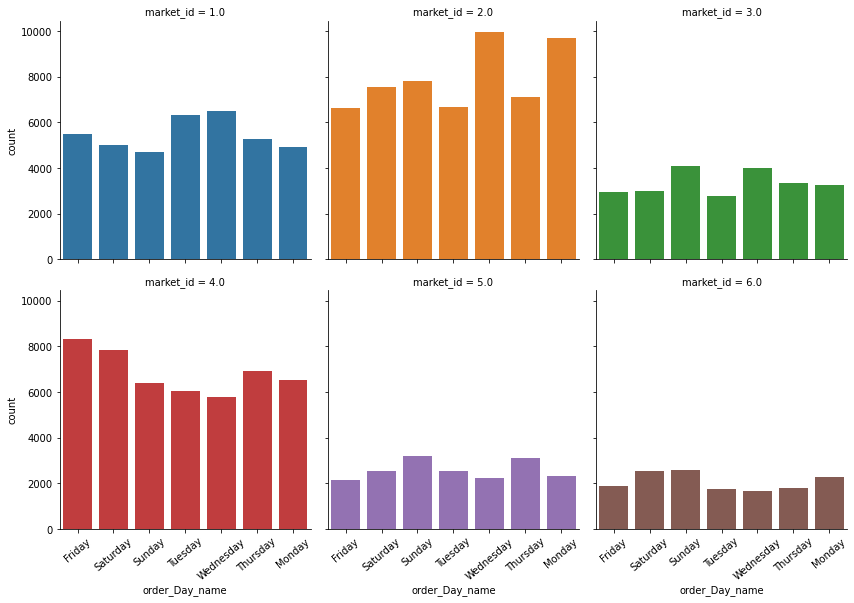

In [183]:
#checking order count on each Market_id per day
g = sns.FacetGrid(train_df, col="market_id", col_wrap=3,height=4, aspect=1,hue="market_id")
g.map(sns.countplot, "order_Day_name")
g.set_xticklabels( rotation=40)

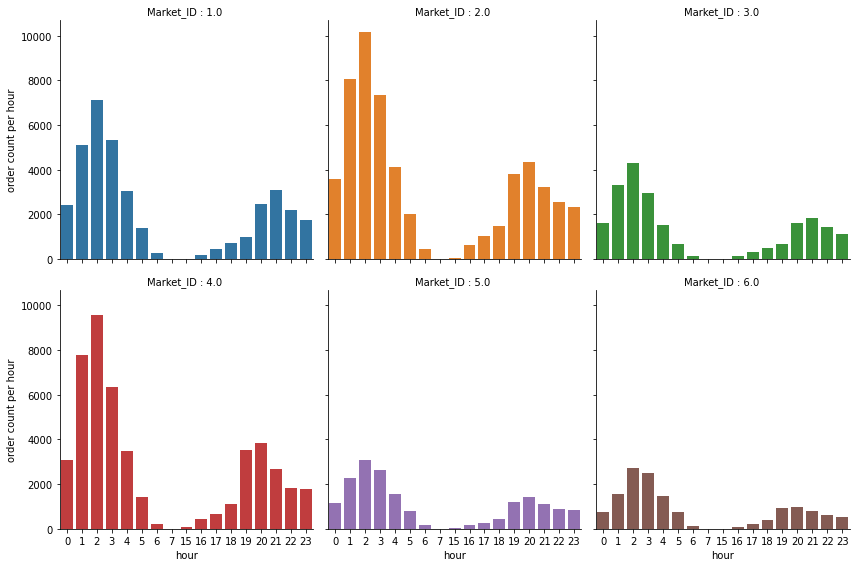

In [184]:
#checking order count on each Market_id per hour
g = sns.FacetGrid(train_df, col="market_id", col_wrap=3,height=4, aspect=1,hue="market_id")
g.map(sns.countplot, "order_hour")
g.set_axis_labels("hour","order count per hour")
g.set_titles(col_template="Market_ID : {col_name} ", row_template="{row_name}")

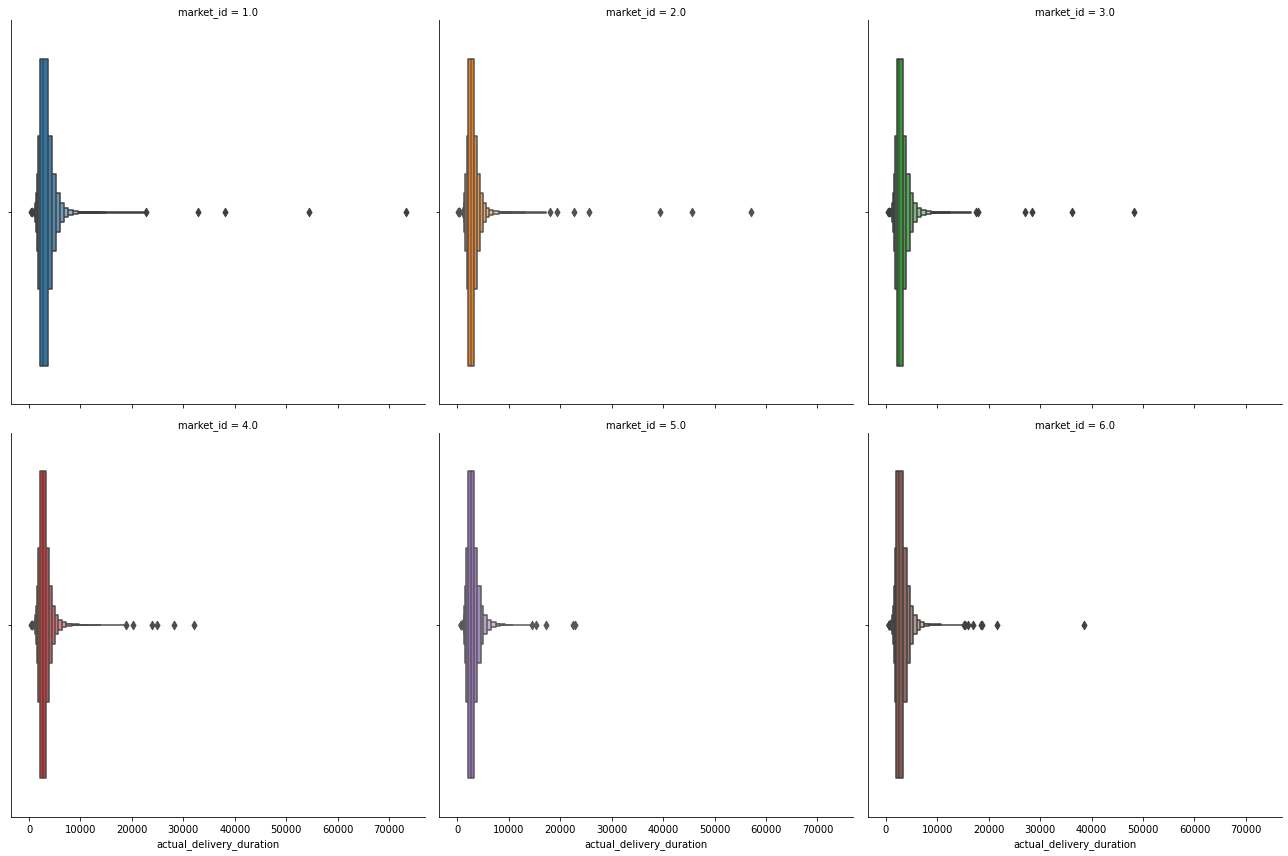

In [185]:
# checking delivery time on Market_ID
g = sns.FacetGrid(train_df, col="market_id", height=6, aspect=1, col_wrap=3,hue="market_id")
g.map(sns.boxenplot, "actual_delivery_duration") 

#### There are some outliers in the deliveries. Some orders took more than 6 hours. That could happen because of some features like a preorder or promotion of which I'm not aware. Or, simply, there could be noise in the dataset. I decided to use 8000s (~2,15 hours) as a threshold for delivery and then remove any records greater than this threshold for actual delivery.



In [186]:
# removing order took more than 8000 secods to deliver

train_df=train_df[train_df.actual_delivery_duration<8000]



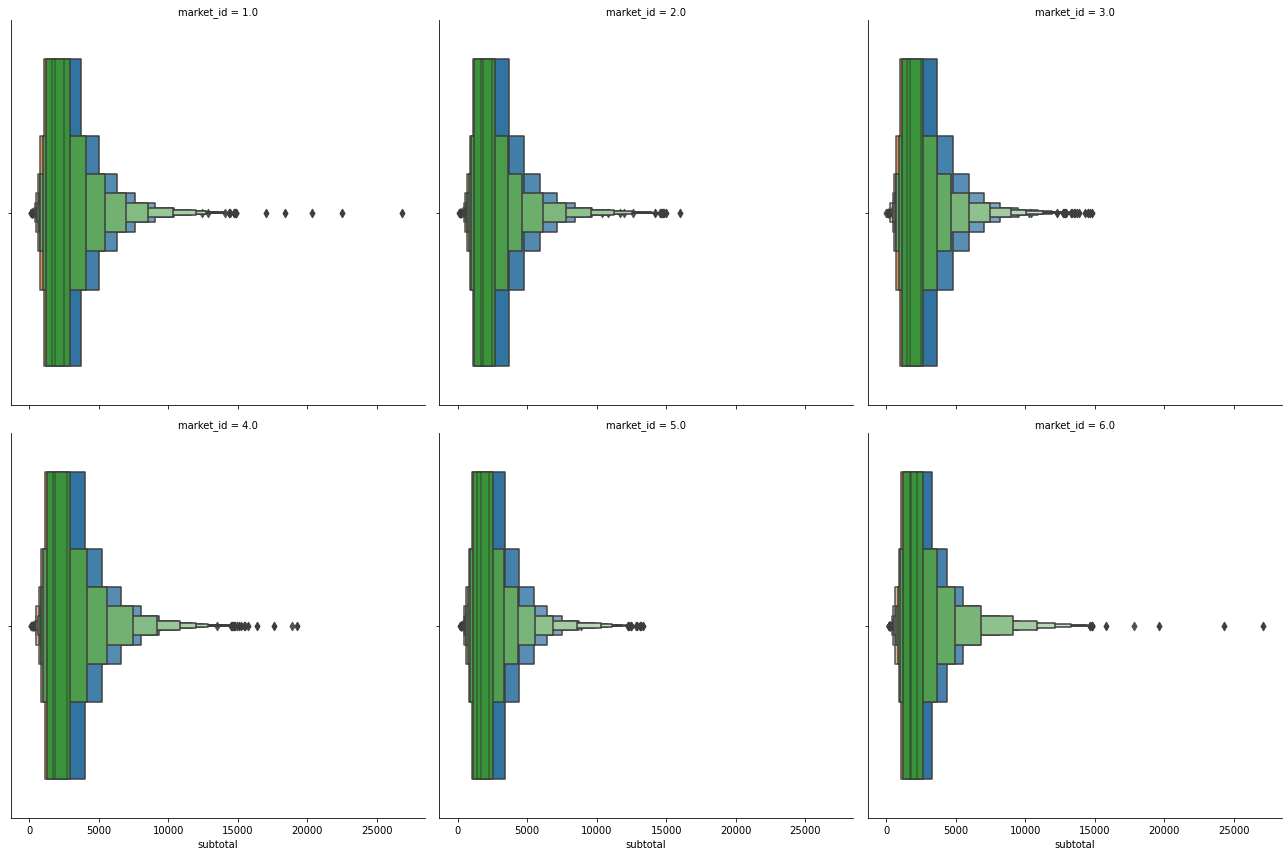

In [187]:
# checking delivery time on Market_ID
g = sns.FacetGrid(train_df, col="market_id", height=6, aspect=1, col_wrap=3,hue="time_group")
g.map(sns.boxenplot, "subtotal") 

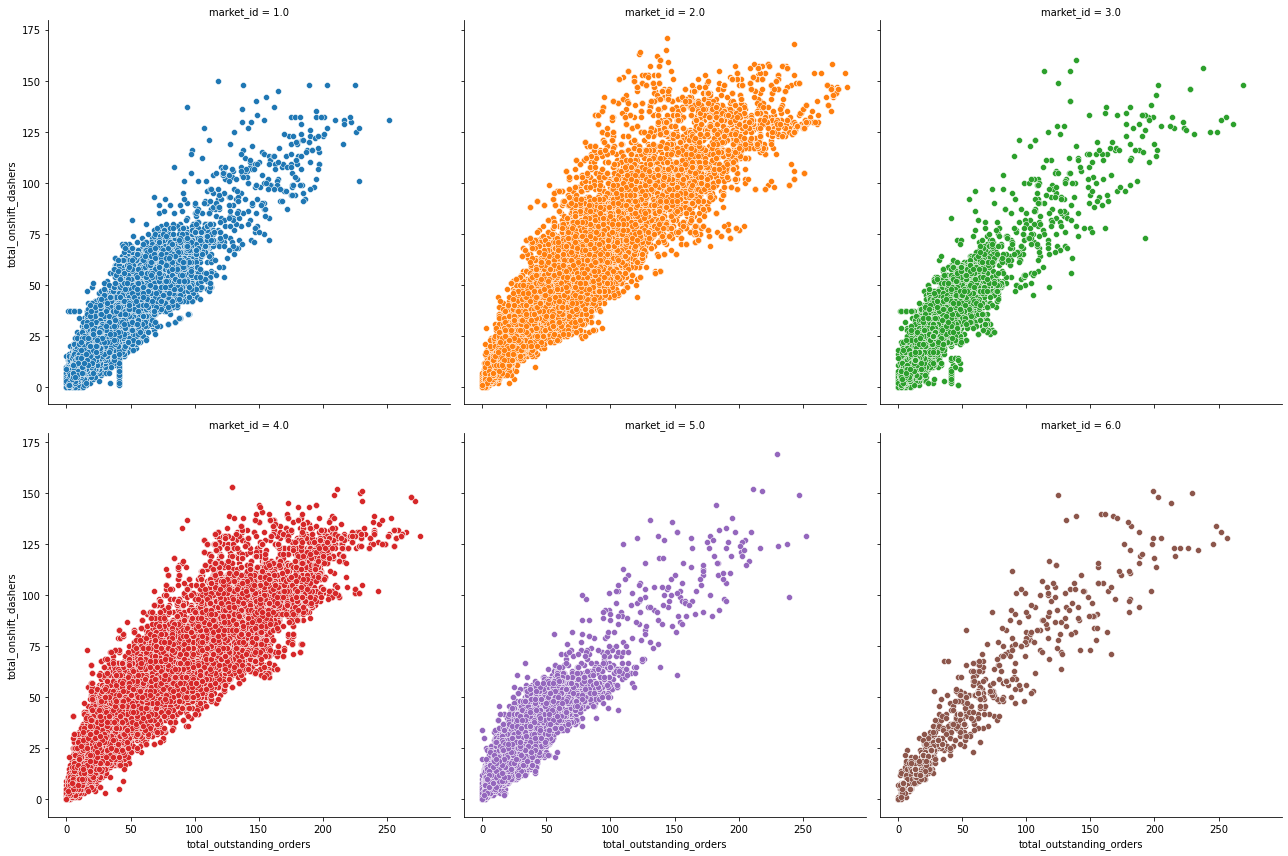

In [188]:
# total_outstanding_orders vs total_onshift_dashers on each Market_ID
g = sns.FacetGrid(train_df, col="market_id", height=6, aspect=1, col_wrap=3,hue="market_id")
g.map(sns.scatterplot, 'total_outstanding_orders',"total_onshift_dashers") 

# Machie Learning Models


<div class="alert alert-info">

- Random Forest
- CatBoost
- XGBoost
</div>



### Random Forest
- First use the GridSearch to optimize the model then calculate MSE and MAE

In [229]:

n_estimators = [500,400]

# Number of features to consider at every split
max_features = ['sqrt'] # already check and sqrt was the best remove others to save time when running again

# Maximum number of levels in tree
max_depth = [8]  # already check and 8 was the best

# Minimum number of samples required at each leaf node
min_samples_leaf = [ 4,8]

# Method of selecting samples for training each tree
bootstrap = [True] # already check and True was the best

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



# Use the random grid to search for best hyperparameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV



RF = RandomForestRegressor()
GS_RF= GridSearchCV(estimator = RF, param_grid = random_grid, 
                             cv = 4,  n_jobs = -1)


# remove 2 rows with mising values on total_onshift_dashers

train_df=train_df[train_df.total_onshift_dashers.notna()]

X=train_df[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
           'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]


y=train_df.actual_delivery_duration
# Fit the random search model
GS_RF.fit(X, y)

print(GS_RF.best_params_)


{'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}


In [117]:
# create results to capture results on each model
results={}

In [118]:
# use the suggest parameter and calculate model performance

from sklearn.ensemble import RandomForestRegressor

RF=RandomForestRegressor(bootstrap= True,max_depth= 8,max_features='sqrt', min_samples_leaf= 4,n_estimators= 400)

train_df=train_df[train_df.total_busy_dashers.notna()]

X=train_df[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
           'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]


y=train_df.actual_delivery_duration

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
RF.fit(X_train, y_train)



# MAE and MSE

from sklearn.metrics import mean_squared_error,mean_absolute_error    
metrics=[mean_absolute_error, mean_squared_error]
for i in metrics:
    print('{} of testing data'.format(str(i)),i(RF.predict(X_train),y_train))
    print('{} of training data'.format(str(i)),i(RF.predict(X_test),y_test))
    
results['Random Forest']=[mean_absolute_error(RF.predict(X_test),y_test),
                          mean_squared_error(RF.predict(X_test),y_test)]


<function mean_absolute_error at 0x7fd10d9ec200> of testing data 694.7397728710777
<function mean_absolute_error at 0x7fd10d9ec200> of training data 707.0253160412445
<function mean_squared_error at 0x7fd10d9ec440> of testing data 838206.1872951367
<function mean_squared_error at 0x7fd10d9ec440> of training data 863690.118430797


# Catboost

In [122]:
import catboost
print('catboost version:', catboost.__version__)
from catboost import CatBoostRegressor,Pool

catboost version: 1.0.3


In [127]:
X=train_df[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
           'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]

y=train_df.actual_delivery_duration

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                 test_size=0.25, 
                                                 random_state=1)


params = {'iterations':15000,
        'learning_rate':0.01,
        'depth':3,
        'loss_function':'RMSE',
        'eval_metric':'RMSE',
        'random_seed':55,
        'metric_period':200,  
        'od_type':"Iter",  
        'od_wait':20,  
        'verbose':True,
        'use_best_model':True}

model_regressor = CatBoostRegressor(**params)

model_regressor.fit(X_train, y_train, 
          eval_set=(X_test, y_test),  
          use_best_model=True,silent=True ,
          plot= True,early_stopping_rounds=20,save_snapshot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [128]:
shap_values = model_regressor.get_feature_importance(Pool(X_test, label=y_test) , type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])


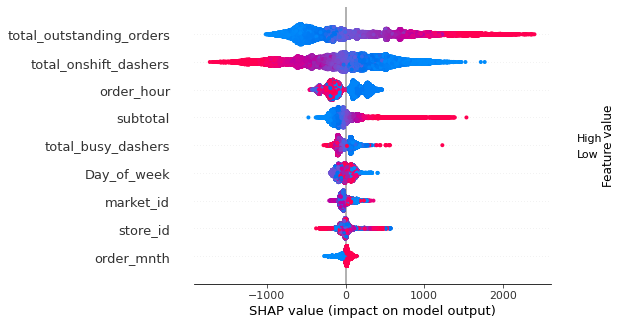

In [129]:
shap.summary_plot(shap_values, X_test)

In [130]:
metrics=[mean_absolute_error, mean_squared_error]
for i in metrics:
    print('{} of testing data'.format(i),i(RF.predict(X_train),y_train))
    print('{} of training data'.format(i),i(RF.predict(X_test),y_test))
    
results['CatBoost']=[mean_absolute_error(model_regressor.predict(X_test),y_test),
                     mean_squared_error(model_regressor.predict(X_test),y_test)]


<function mean_absolute_error at 0x7fd10d9ec200> of testing data 696.9718707480829
<function mean_absolute_error at 0x7fd10d9ec200> of training data 700.3290224102286
<function mean_squared_error at 0x7fd10d9ec440> of testing data 842143.2919498176
<function mean_squared_error at 0x7fd10d9ec440> of training data 851878.8044667551


# XGBoost

    1-GridSearch to optimize model
    2-Train and Evaluate model

In [239]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV



X=train_df[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
           'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]


y=train_df.actual_delivery_duration



params = {'max_depth': [6,9,12],
          'learning_rate': [0.01], # already checked and 0.01 is better use only 1 to save time in training
          'n_estimators': [700],
          'colsample_bytree': [ 0.5,0.7]}


xgbr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=0,
                  cv=4)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)

[20:10:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [131]:
# using parameter from GridSearch

XGBR=xgb.XGBRegressor(verbosity=0, n_jobs=-1, colsample_bytree= 0.7, 
                      learning_rate=0.01, max_depth= 12, n_estimators= 700)


X=train_df[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
           'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]


y=train_df.actual_delivery_duration


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

XGBR.fit(X_train, y_train)


metrics=[mean_absolute_error, mean_squared_error]
for i in metrics:
    print('{} of testing data'.format(i),i(XGBR.predict(X_train),y_train))
    print('{} of training data'.format(i),i(XGBR.predict(X_test),y_test))
    
results['XGBoost']=[mean_absolute_error(XGBR.predict(X_test),y_test),
                    mean_squared_error(XGBR.predict(X_test),y_test)]



<function mean_absolute_error at 0x7fd10d9ec200> of testing data 515.1197476941287
<function mean_absolute_error at 0x7fd10d9ec200> of training data 652.9172294853795
<function mean_squared_error at 0x7fd10d9ec440> of testing data 468560.21338280925
<function mean_squared_error at 0x7fd10d9ec440> of training data 751022.7396740306


In [132]:
import shap
# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(XGBR)
shap_values = explainer.shap_values(X_test)


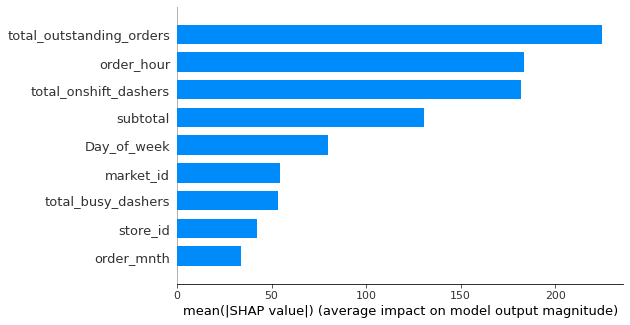

In [133]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

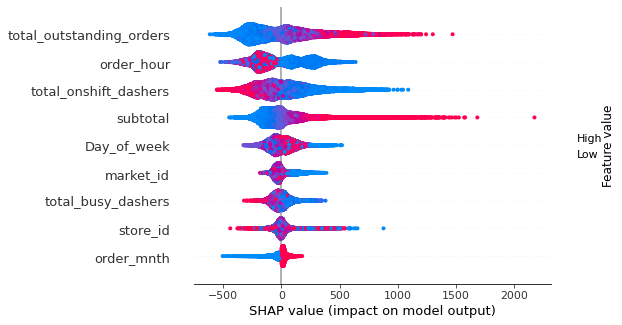

In [134]:
shap.summary_plot(shap_values, X_test)

In [136]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],figsize=(10,10))

In [143]:
# Comparing Results

results=pd.DataFrame(results, index=['mean_absolute_error (MAE)','mean_squared_error (MSE)'])
results

,Random Forest,CatBoost,XGBoost
mean_absolute_error (MAE),707.025316,663.453103,652.917229
mean_squared_error (MSE),863690.118431,773598.680306,751022.739674



<div class="alert alert-info">
Since each city’s traffic conditions are different and our goal is to create a most accurate prediction, for the next step, I trained a separate model for each market ID and used these models to predict delivery time on testing data based on their market ID. 
 </div>


In [189]:
models={}
for i in train_df.market_id.unique():
    X=train_df[train_df.market_id==i]
    y=X.actual_delivery_duration
    X=X[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
         'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]
    
    
    
    models[i]=xgb.XGBRegressor(verbosity=0, n_jobs=-1, colsample_bytree= 0.7, 
                      learning_rate=0.01, max_depth= 9, n_estimators= 700)
    
    models[i].fit(X,y)

print(models)

{1.0: XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
             n_estimators=700, n_jobs=-1, verbosity=0), 2.0: XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
             n_estimators=700, n_jobs=-1, verbosity=0), 3.0: XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
             n_estimators=700, n_jobs=-1, verbosity=0), 4.0: XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
             n_estimators=700, n_jobs=-1, verbosity=0), 5.0: XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
             n_estimators=700, n_jobs=-1, verbosity=0), 6.0: XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
             n_estimators=700, n_jobs=-1, verbosity=0)}


In [214]:
for i in train_df.market_id.unique():
    X=train_df[train_df.market_id==i]
    y=X.actual_delivery_duration
    X=X[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
         'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]
    
    print('mean_absolute_error market_id : {}  '.format(i),mean_absolute_error(models[i].predict(X),y))

mean_absolute_error market_id : 1.0   642.1356049266435
mean_absolute_error market_id : 2.0   504.0837850515425
mean_absolute_error market_id : 3.0   547.0174053756014
mean_absolute_error market_id : 4.0   495.6538238819517
mean_absolute_error market_id : 5.0   437.8921642795079
mean_absolute_error market_id : 6.0   547.8151363963128


<div class="alert alert-info">

Prediction Based on Market ID

</div>

In [325]:
#fill with dummmy number rhwn replace it with prediction
test_df['predict_delivery_time']=-2

# predict based on city / Market_ID
for i in test_df.market_id.unique():
    
    X=test_df[test_df.market_id==i]
    idx=X.delivery_id
    X=X[['market_id','store_id','subtotal','total_onshift_dashers', 'total_busy_dashers',
         'total_outstanding_orders','Day_of_week','order_mnth', 'order_hour']]
    
    predicted=models[i].predict(X)
    test_df.loc[test_df.market_id==i, 'predict_delivery_time'] =predicted
    

In [328]:
test_df.to_csv('predicted_data.csv')  